In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle
import pandas as pd

from sim_util import run_torch_sim

### 1. Get initial expert data

In [3]:
pickle_in = open("expert_data/Reacher-v2.pkl","rb")
reacher_expert = pickle.load(pickle_in)

observations = reacher_expert['observations']

actions = reacher_expert['actions']
actions = actions.reshape(-1, 2)
observations.shape, actions.shape

((1000, 11), (1000, 2))

In [5]:
def training_loop(loader_train, model, optimizer, epochs=1, print_every=1):
    criterion = nn.MSELoss()
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()
            scores = model(x)
            loss = criterion(scores, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
#         if e % print_every == 0:
#             print('Epoch %d, loss = %.4f' % (e, loss.item()))
#     print('Epoch %d, loss = %.4f' % (e, loss.item()))
    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [6]:
def train_model(observations, actions, epochs=45):
    num_train = len(observations)

    observations_tensor = torch.from_numpy(observations).float()
    actions_tensor = torch.from_numpy(actions).float()
    dataset = torch.utils.data.TensorDataset(observations_tensor, actions_tensor)
    loader_train = torch.utils.data.DataLoader(dataset, batch_size=128, 
                              sampler=torch.utils.data.sampler.SubsetRandomSampler(range(num_train)))

    model = nn.Sequential(
        nn.Linear(11, 30),
        nn.ReLU(),
        nn.Linear(30, 15),
        nn.ReLU(),
        nn.Linear(15, 2)
    )

    model.apply(init_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    training_loop(loader_train, model, optimizer, epochs=epochs)
    return model

In [7]:
import os
import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy

def get_expert_data(states, expert_fn):
    with tf.Session():
        tf_util.initialize()
        expert_labels = []
        expert_labels = expert_fn(states)
        
    return expert_labels

In [8]:
# 1. Train model from expert dataset
# 2. Make actions in environment
# 3. Get expert predictions on this actions
# 4. Add this labeled data to the dataset

def DAgger(trainer, observations, actions, env, expert_policy_file, iterations=10, num_rollouts=20):
    expert_fn = load_policy.load_policy(expert_policy_file)
    returns = []
    for i in range(iterations):
        model = trainer(observations, actions)
        new_actions, new_returns = run_torch_sim(model, env, num_rollouts=num_rollouts)
        returns.append(new_returns)
        # write new function that takes observations from actions and label them:
        expert_labels = get_expert_data(new_actions['observations'], expert_fn)
        observations = np.concatenate((observations, new_actions['observations']), axis=0)
        actions = np.concatenate((actions, expert_labels), axis=0)
    
    return model, returns

In [43]:
model, returns = DAgger(train_model, observations, actions, 'Reacher-v2', 'experts/Reacher-v2.pkl', iterations=25)

obs (1, 11) (1, 11)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explic

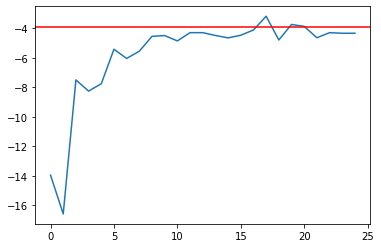

In [45]:
plt.plot([np.mean(x) for x in returns])
plt.axhline(-3.90752964581997, color='r')
plt.show()

### 2. More complex task

In [2]:
pickle_in = open("expert_data/Walker2d-v2.pkl","rb")
reacher_expert = pickle.load(pickle_in)

observations = reacher_expert['observations']

actions = reacher_expert['actions']
actions = actions.reshape(-1, actions.shape[2])
observations.shape, actions.shape

((20000, 17), (20000, 6))

In [3]:
def train_model_2(observations, actions, epochs=45):
    num_train = len(observations)

    observations_tensor = torch.from_numpy(observations).float()
    actions_tensor = torch.from_numpy(actions).float()
    dataset = torch.utils.data.TensorDataset(observations_tensor, actions_tensor)
    loader_train = torch.utils.data.DataLoader(dataset, batch_size=128, 
                              sampler=torch.utils.data.sampler.SubsetRandomSampler(range(num_train)))

    model = nn.Sequential(
        nn.Linear(17, 30),
        nn.ReLU(),
        nn.Linear(30, 15),
        nn.ReLU(),
        nn.Linear(15, 6)
    )

    model.apply(init_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    training_loop(loader_train, model, optimizer, epochs=epochs)
    return model

In [9]:
model, returns = DAgger(train_model_2, observations, actions, 'Walker2d-v2', 
                        'experts/Walker2d-v2.pkl', iterations=5)


obs (1, 17) (1, 17)


/home/raznem/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


running build_ext
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
100/1000
100/1000
100/1000
100/1000
Instructions for updating:
Please use tf.global_variables instead.

Instructions for updating:
Use `tf.variables_initializer` instead.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
100/1000
200/1000
100/1000
100/1000
200/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
100/1000
200/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
100/1000
200/1000
100/1000
200/1000
300/1000
100/1000
100/1000
200/1000
100/1000
100/1000
100/1000
200/1000
300/1000
100/1000
100/1000
200/1000
100/1000
200/1000
100/1000
100/1000
200/1000
WARN: gym.spaces.Box autodetected dty

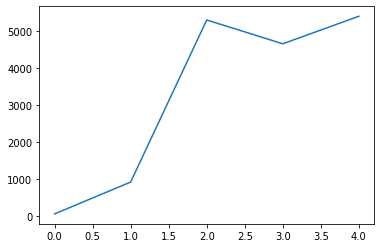

In [10]:
plt.plot([np.mean(x) for x in returns])
plt.show()

In [11]:
### SAVE THE MODEL THEN RUN SIMULAION BELOW !!!
torch.save(model, open("policies/walker2d_DAgger.md", 'wb'))